In [1]:
import os
import shutil
import tempfile
import time
import glob

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from monai.data.utils import pad_list_data_collate
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import random

import nibabel as nib

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

#print_config()

In [2]:
DEVICE_TYPE = "cuda:0"

In [3]:
ROOT_DIR = "/home/fehrdelt/bettik/"
#ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

set_determinism(0)

In [4]:
IMAGE_SIZE = 128

In [5]:
train_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/train.csv")
train_images_path = []

with open(train_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):
        #print(line)
        train_images_path.append(ROOT_DIR+line[0])

val_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/val.csv")
val_images_path = []

with open(val_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        val_images_path.append(ROOT_DIR+line[0])

test_reconstruction_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/test.csv")
test_reconstruction_images_path = []

with open(test_reconstruction_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_reconstruction_images_path.append(ROOT_DIR+line[0])


1576it [00:00, 222162.50it/s]
197it [00:00, 69999.82it/s]
197it [00:00, 84807.34it/s]


In [6]:
test_unhealthy_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_aini-stroke_unhealthy_test/ADC_aini-stroke_unhealthy_test.csv")
test_unhealthy_images_path = []

with open(test_unhealthy_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_unhealthy_images_path.append(ROOT_DIR+line[0])

445it [00:00, 24829.92it/s]


In [7]:
#train_datalist = sorted(train_images_path)
train_datalist = train_images_path

#val_datalist = sorted(val_images_path)
val_datalist = val_images_path

#val_datalist = sorted(val_images_path)
test_reconstruction_datalist = test_reconstruction_images_path

test_unhealthy_datalist = test_unhealthy_images_path

batch_size = 64
num_workers = 4


In [8]:
class Get2DSlice(transforms.Transform):
    """
    Fetch the middle slice of a 3D volume.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.offset = offset

    def __call__(self, data):
        #print(data.shape)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.offset]

In [9]:
class Get2DSliceWithRandomOffset(transforms.RandomizableTransform):
    """
    Will return the middle slice with a random offset in addition to the specified fixed offset.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        fixed_offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.fixed_offset = fixed_offset
        self.rand_offset = 0


    def randomize(self):
        super().randomize(None)
        self.rand_offset = random.randint(-1, 1)

    def __call__(self, data):
        #print(data.shape)
        self.randomize()

        #print(self.rand_offset)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.fixed_offset+self.rand_offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.fixed_offset+self.rand_offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.fixed_offset+self.rand_offset]

In [10]:

train_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.RandAffine(prob=0.2, rotate_range=(0.15, 0.15, 0.15)),#+- 0.15 radians for each axis
        Get2DSlice(axis=2, offset=0), #Get2DSliceWithRandomOffset(axis=2, fixed_offset=0), #28
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandScaleCrop(roi_scale=0.9, max_roi_scale=1.1, random_size=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms) #TODO datalist[:32]
train_loader = DataLoader(
    #collate_fn=pad_list_data_collate: any tensors are centrally padded to match the shape of the biggest tensor in each dimension
    train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True, collate_fn=pad_list_data_collate
)



Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1576/1576 [04:34<00:00,  5.74it/s]


In [11]:


val_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=0),  # 28
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:17<00:00, 11.31it/s]


In [12]:



test_reconstruction_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=0),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_reconstruction_ds = CacheDataset(data=test_reconstruction_datalist, transform=test_reconstruction_transforms)
test_reconstruction_loader = DataLoader(
    test_reconstruction_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [00:21<00:00,  9.27it/s]


In [13]:
test_unhealthy_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_unhealthy_ds = CacheDataset(data=test_unhealthy_datalist, transform=test_unhealthy_transforms)
test_unhealthy_loader = DataLoader(
    test_unhealthy_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:26<00:00, 16.76it/s]


In [16]:
print(batch[0, 0])

metatensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Visualizing batch 0, batch shape: torch.Size([64, 1, 128, 128])


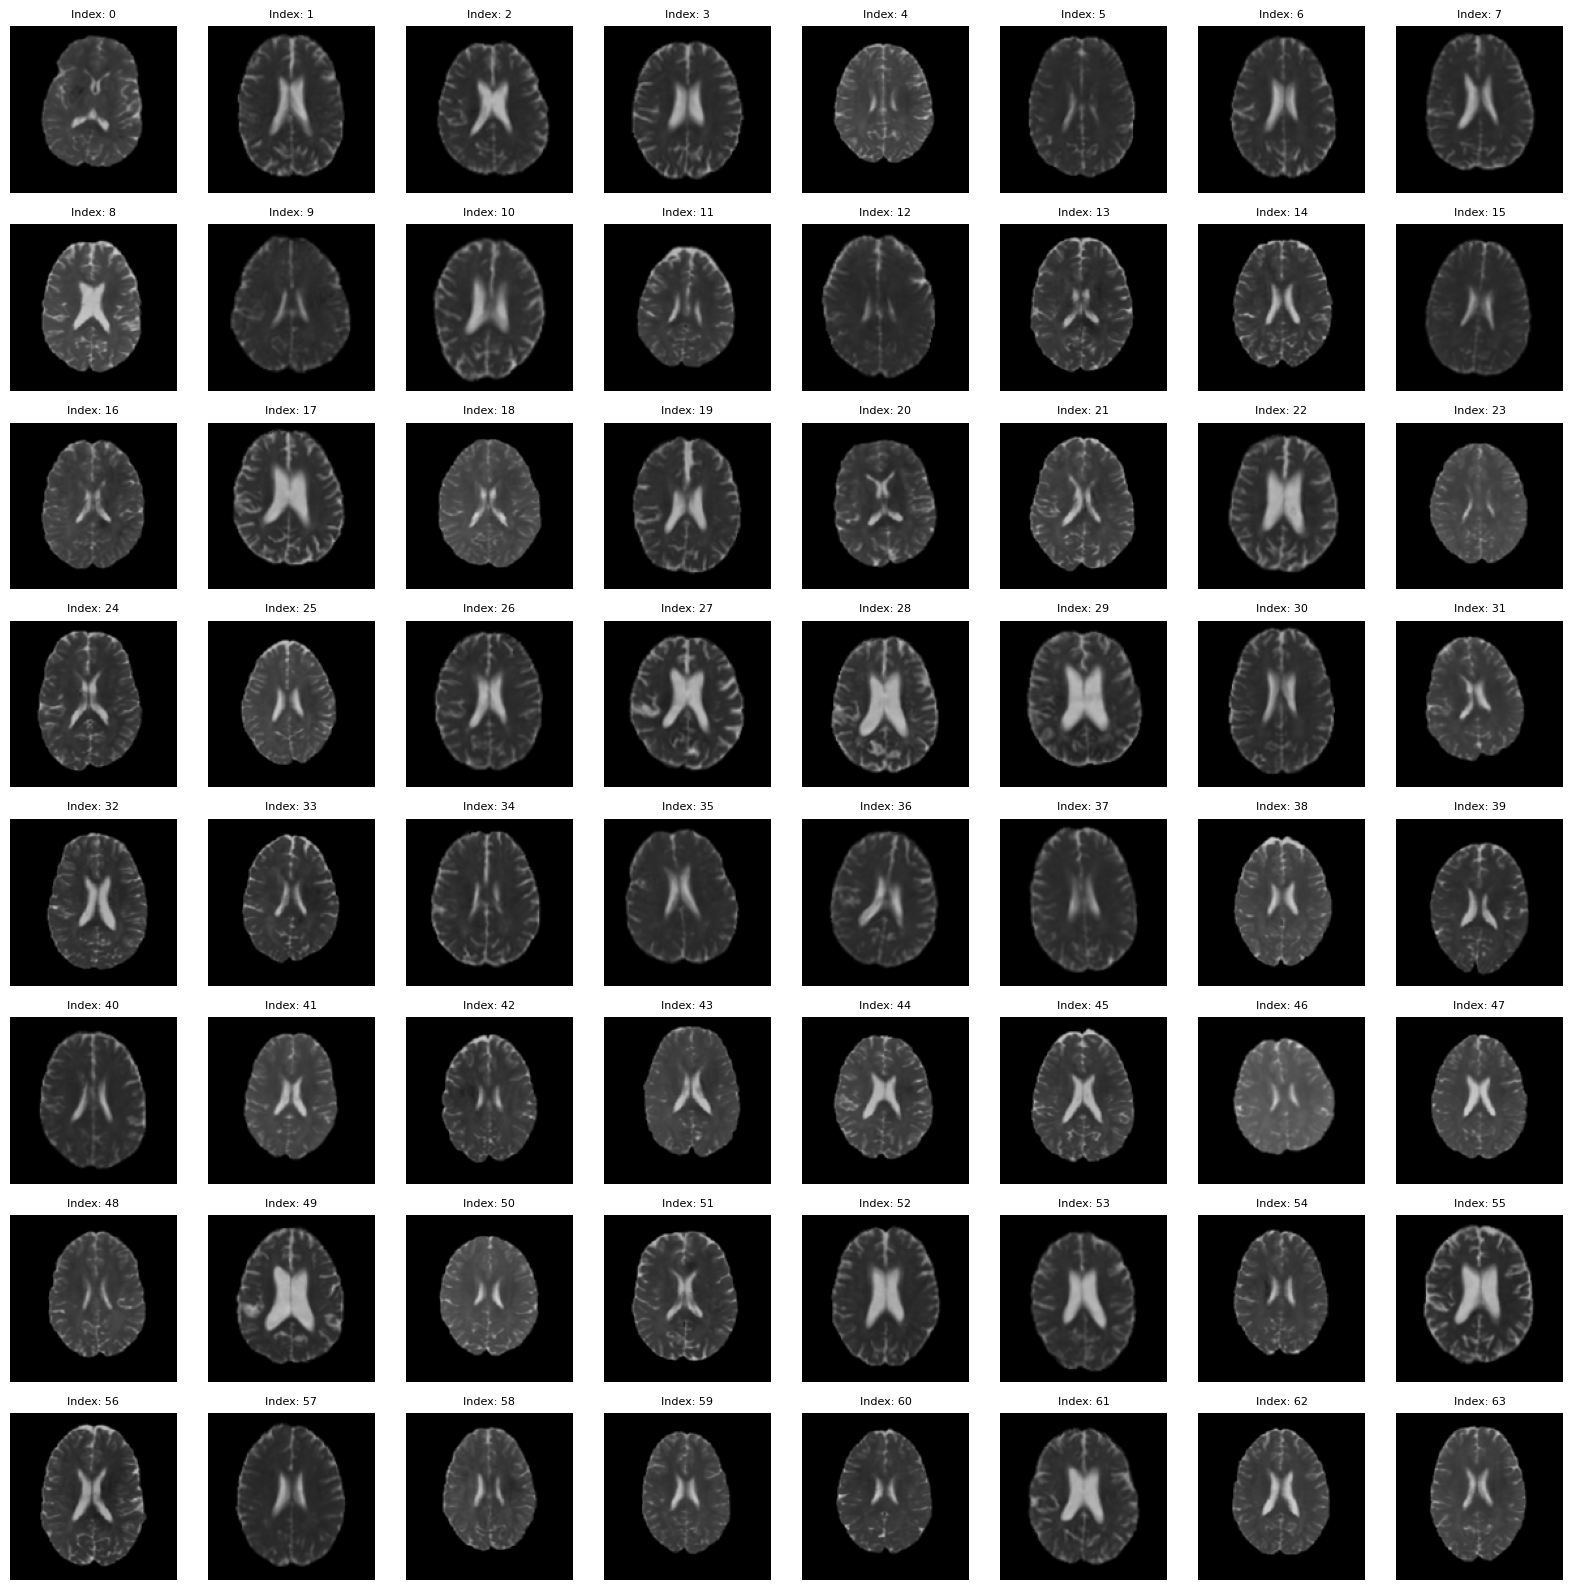

In [64]:
i = 0 # Specify the batch index you want to visualize

for batch_idx, batch in enumerate(train_loader):
    if batch_idx == i:
        
        print(f"Visualizing batch {i}, batch shape: {batch.shape}")

        grid_size = int(np.ceil(np.sqrt(batch.shape[0])))  # Calculate grid size

        fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(16, 16))

        axes = axes.flatten()  # Flatten the axes for easier indexing

        for img_idx in range(batch.shape[0]):
            axes[img_idx].imshow(batch[img_idx, 0], cmap="gray", vmin=0, vmax=1)
            axes[img_idx].set_title(f"Index: {i*64+img_idx}", fontsize=8)
            axes[img_idx].axis("off")
        
        # Hide unused subplots
        for unused_idx in range(batch.shape[0], len(axes)):
            axes[unused_idx].axis("off")
        
        plt.tight_layout()
        plt.show()
        
        break

In [50]:
print(train_datalist[1242])

/home/fehrdelt/bettik/datasets/ADC_Human_Connectome_Project_Young_Adult_HCP-YA_resized128/168139.nii.gz
